# **Exercise 1 for the class EE-568 Theory and Methods of Reinforcement Learning at EPFL Spring 2025**

## **by Prof. Volkan Cevher**

In [1]:
import os
from typing import List

import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys

sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from plot import plot_log_lines, plot_lines
%load_ext autoreload
%autoreload 2

# **Dynamic Programming exercise**

### **值迭代与策略迭代前的准备工作**

在实现 **价值迭代 (Value Iteration)** 或 **策略迭代 (Policy Iteration)** 之前，我们将使用 **第 1 和第 2 讲** 课件中介绍的算子，包括： $(T V)(s)$, $\mathcal{G}$, $T^{\pi}$

### **环境初始化**

我们首先使用 `src` 文件夹中的库来实例化一个 **GridWorld** 环境。该环境由 `GridWorldEnvironment` 类创建，并接受以下四个参数：

| 参数            | 描述 |
|---------------|------|
| reward_mode | 整数值，取 0 到 3 之间，不同值对应不同的奖励模式。 |
| size        | GridWorld 的大小。 |
| prop        | 表示智能体未按照所选动作执行，而是随机选择其他动作的概率。 |
| gamma       | 环境的折扣因子。 |




In [2]:
# 环境参数
reward_mode = 2 # put an image to show which is the reward
size = 10 
prop = 0
gamma=0.99 # rename discount_factor

# 创建环境
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

# 创建求解器
solver = MDPsolver(gridworld)
solver.value_iteration()

### **网格世界环境-例子**

下面我们介绍如何访问网格世界环境，即如何获取奖励、转移矩阵和折扣因子。


### **与网格世界实例交互**

| 命令 | 功能描述 |
|------|---------|
| print(gridworld.n_states) | 返回状态的数量 |
| print(gridworld.n_actions) | 返回动作的数量 |
| print(gridworld.r) | 返回一个矩阵，每个元素表示对应的（状态，动作）对的奖励 |
| print(gridworld.gamma) | 返回折扣因子 |
| print(gridworld.sparseT[action]) | 输入：动作，返回一个矩阵，包含该动作对应的状态转移概率 |

<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">  


In [3]:
size = 3
gridworld_example = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

print(gridworld_example.n_states)
print(gridworld_example.n_actions)
print(gridworld_example.r)            # r(s,a) 9x4 的矩阵 (9个state 4个action)
print("\n")
print(gridworld_example.sparseT[0])   # 稀疏-状态转移矩阵 P(s'|s,a) a = "↑"
                                      # Coords(s,s') 在 action = a 的情况下，状态s 变化到 s' 的概率
# state        # action
## 0 1 2       ## 0="↑"
## 3 4 5       ## 1="→"
## 6 7 8       ## 2="↓"
##             ## 3="←"

9
4
[[   0.    0.    0.    0.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9 stored elements and shape (9, 9)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 0)	1.0
  (4, 1)	1.0
  (5, 2)	1.0
  (6, 3)	1.0
  (7, 4)	1.0
  (8, 5)	1.0


然后，我们设置求解器对象 `solver`，该对象将实现评估生成策略值所需的例程

我们将使用此求解器来计算最优值函数，以衡量由值迭代或策略迭代生成的策略的次优性

要访问最优值函数，请使用 `solver.v`

In [4]:
# 例子
solver_example = MDPsolver(gridworld_example)
solver_example.value_iteration()

print(solver_example.v)
print(solver_example.policy)

#  State        Policy      action = pi(state)
## 0  1  2      ↑ ← ←
## 3  4  5      ↑ ↑ ↑
## 6  7  8      ↑ ← ↑


[   0.         -1.         -1.99       -1.       -100.99       -2.9701
   -1.99       -2.9701     -3.940399]
[0 3 3 0 0 0 0 3 0]


## **Ex 1: 值迭代 Value Iteration [25 pts.]**

### 1.1 Implement value iteration

### **贝尔曼 - 最优算子**

$$(TV)(s) = \max_{a \in A} \left[ r(s,a) + \gamma \sum_{s' \in S} \mathbb{P}(s' | s,a) \cdot V(s') \right] $$  

$$ \vec q = \vec r + \gamma \cdot \vec P (a) \cdot \vec v $$

$$ \vec v_{t+1} = \arg \max \vec q$$

In [5]:
def value_iteration(env, tol=1e-10):
    """Inplementation of value iteration, note that the implementation is based on value iteration mentioned in the lecture.
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        policies: policy  at each iteration (list)
        vs: value functions at each iteration (list)
    """

    # 初始化
    policies = []
    vs = []
    v = np.zeros(env.n_states)                    # initialize value function
    q = np.zeros((env.n_states, env.n_actions))   # initialize Q-value function
    
    # 迭代
    while True:
        v_old = np.copy(v)      # save a copy of value function for the convergence criterion at the step

        # 贝尔曼-最优算子
        for a in range(env.n_actions):
            q[:, a] = env.r[:,a] + env.gamma * env.sparseT[a].dot(v)  
            # q = 9x4 矩阵 (代表每个(s,a)组合下的 回报期望 = 即刻回报 + 折扣未来回报)

        v = np.max(q,axis = 1)  # 选出每行最大值
        # v = 9x1 向量 (选出最优的a使得回报最大)

        policies.append(np.argmax(q, axis = 1))    # 每次 V值迭代后 Policy 的变化
        vs.append(v)

        if np.linalg.norm(v - v_old) < tol: # convergence criterion
            break
            
    return policies, vs

In [6]:
policies, vs = value_iteration(gridworld)

### 1.2: Evaluate the extracted policies
  
根据上面已知策略 $\pi(s)$，从初始值 $V_0(s)$ 计算$V^{\pi}(s)$  
  
使用 **贝尔曼-期望算子** 
- $T^{\pi}(\vec V) = \vec R + \gamma \cdot P \cdot \vec V$      
- $\lim_{t \to \infty} (T^\pi)^t \vec{V}_0 = \vec{V}^\pi$


In [7]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    """Inplementation of policy evaluation through iteratively applying policy value iteration 
    Args:
        policies: a list of policies obtained by section 1.1
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        values: a list of value function for each policy
    """
    values = []

    for pi in policies:
        v = np.zeros(env.n_states)                  # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) # initialize Q-value

        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step


            for a in range(env.n_actions):
                q[:, a] = env.r[:,a] + env.gamma * env.sparseT[a].dot(v)      # calculate Q-value #0000ff TODO
                # q = 9x4 矩阵 (代表每个(s,a)组合下的 回报期望 = 即刻回报 + 折扣未来回报)

            for s in range(env.n_states):
                action_taken = pi[s]          # obtain the action determined by the policy
                v[s] = q[s,action_taken]      # calculate value function by v(s) = Q(s,pi(s))  #0000ff TODO
                # 这里更新 v 不再使用 max 而是使用 policy
            
            # 终止条件
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
                
        values.append(v)

    return values

In [8]:
values = evaluate_policy_sequence(policies, gridworld)

### 1.3: Plot the results 

使用方法 ```plot_lines(list_to_plot, list_name, axis_label, folder, title, x_axis = None, show = False)``` 进行绘图。

计算由值迭代生成的迭代序列 $V_t$ 以及由提取的策略 $\pi_t = \mathcal{G}(V_t)$ 所实现的值函数 $V^{\pi_t}$。你观察到了什么？


### **Answer**
第一次迭代 V 变化非常大，后续迭代过程中 V 的值先行上升，并且达到第18次迭代后 V 的值保持不变

In [9]:
def compute_subopt(values, v_star):
    """
    Args:
        values: a list of value function.
        v_star: the optimal value function obtained by MDP.solver
    Returns:
        subopts: an array indicates the suboptimality.
    """
    subopts = []
    for v in values:
        i = np.argmax(np.abs(v - v_star))
        subopts.append(-v[i] + v_star[i])

    return np.array(subopts)

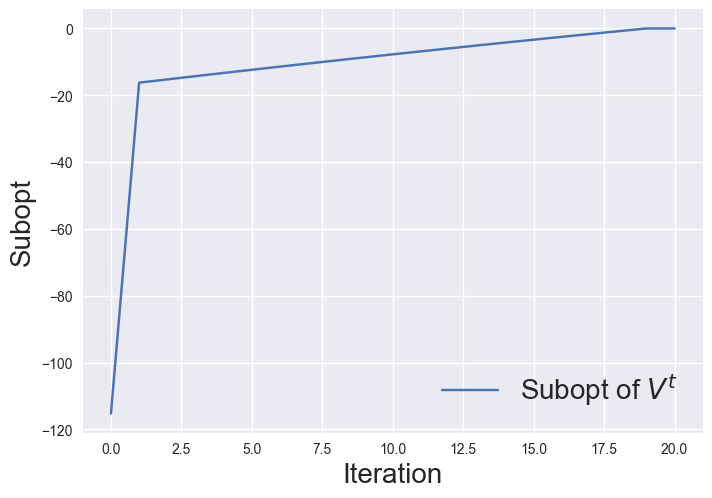

In [10]:
plot_lines([compute_subopt(vs, solver.v)], [r"Subopt of $V^t$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

**Question** : 
- Prove that $T$ is a contraction, that is $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$.
- Why the iterates of Value Iterations are an upper bound to $V^\star$ ? How is this possible considering that $V^\star \triangleq \max_{\pi \in \Pi} V^{\pi}$ ?

**Answers**

- Question 1: 证明在 PPT 中   
- Question 2: 暂时不清楚


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_26584\2314215747.py:1: SyntaxWarning: invalid escape sequence '\p'
  plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)


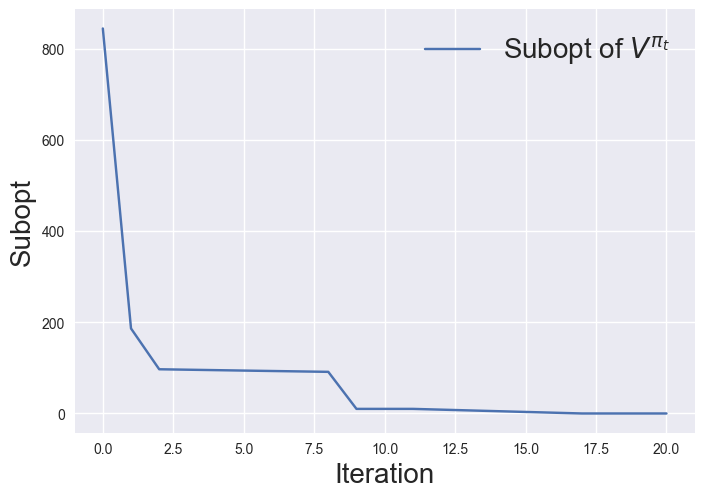

In [11]:
plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

<!-- To better appreciate the difference in the convergence plot use log scale. -->
使用对数坐标，更好的可视化两组收敛

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_26584\4023697979.py:2: SyntaxWarning: invalid escape sequence '\p'
  [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"],


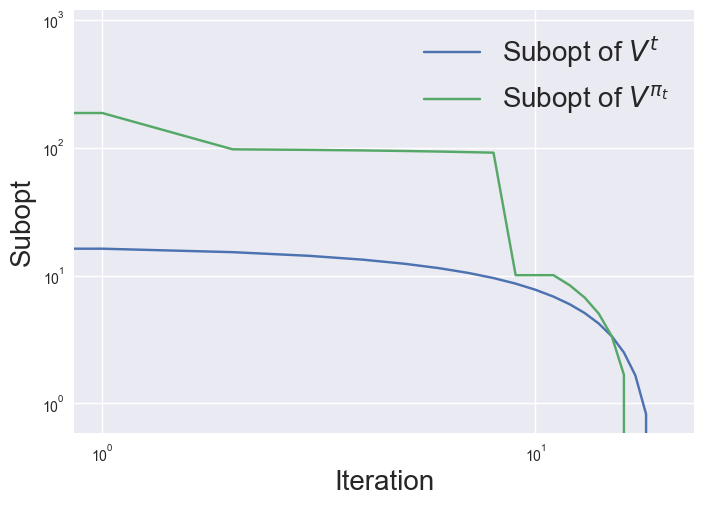

In [12]:
plot_log_lines([-compute_subopt(vs, solver.v), compute_subopt(values, solver.v)], 
               [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"], 
               ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

# 看到最后都收敛到 0 了

# **Ex 2: 策略迭代 Policy Iteration [25 pts.]**

In [13]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))

    while True:

        v_old = np.copy(v)

        # 贝尔曼-期望算子
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v) #TODO #0000ff

        # 策略 期望平均
        for s in range(env.n_states):
            #v[s] = q[s, :].dot(pi[s])  #TODO #0000ff 策略 = 概率分布
            v[s] = q[s, pi[s]]          #TODO #0000ff 策略 = 确定性

        # 终止条件
        if np.linalg.norm(v - v_old) < tol:
            break

    return v, q

In [14]:
def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    # policy = []
    # for s in range(q.shape[0]):
    #     policy.append(np.argmax(q[s,:], axis = 1))  #TODO #0000ff
    
    policy = np.argmax(q, axis = 1)
    return policy

In [15]:
def policy_iteration(env, tol=1e-20):
    """Implementation of policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    v  = np.zeros(env.n_states)
    q  = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)

    while True:
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env, tol)  # 第一步 pi_(t) -> V^pi Q^pi
        pi   = get_greedy_policy(q)           # 第二部 V^pi Q^pi -> pi_(t+1)
        vs.append(v)

        # 终止条件
        if np.linalg.norm(v - v_old) < tol:
            break

    return vs

In [16]:
values_pi=policy_iteration(gridworld)

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_26584\1006779507.py:1: SyntaxWarning: invalid escape sequence '\p'
  plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)


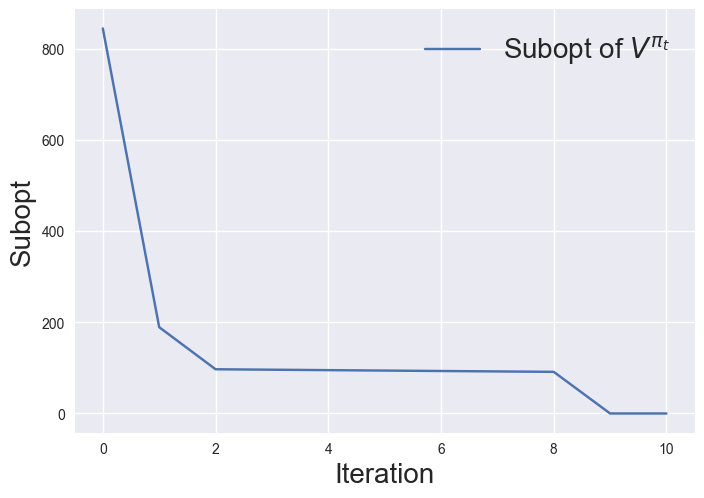

In [17]:
plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

### Compare with Value Iteration

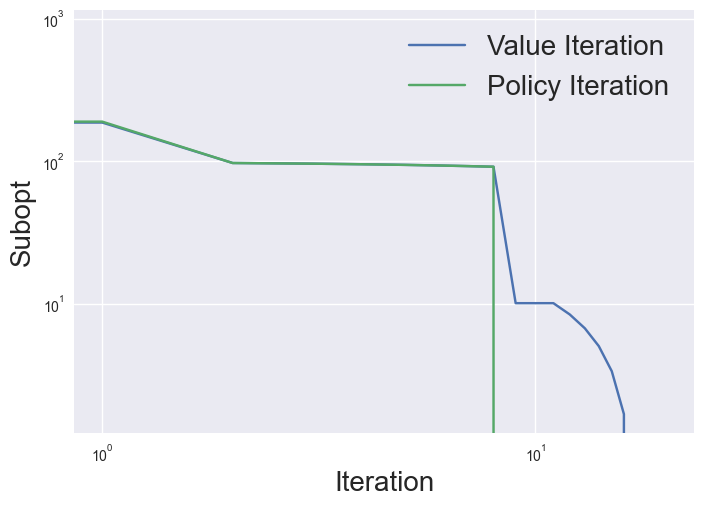

In [18]:
plot_log_lines([compute_subopt(values, solver.v), compute_subopt(values_pi, solver.v)], 
               ["Value Iteration", "Policy Iteration"], 
               ["Iteration", "Subopt"], "figs", "VIvsPI.pdf", show = True)

***Questions :*** 
- Which algorithm converges faster ?
- Is it theoretically expected ? Answer listing the expected number of iterations needed for VI and PI to converge ?


***Answers***

- Question1: 可以看出 Policy Iteration 收敛更快
- Question2: 不知道

***Theory Questions*** 
- Prove the policy improvement theorem.
- Prove that the Bellman operator is monotone elementwise. That is if $V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$.

***Answers***

---
---
---

# **Ex 3: Modified Policy Iteration [25 pts.]**

In this cell you will code and run Modified Value Iteration, that follows this pseudocode:
- $\pi_{k+1} = \mathcal{G}(V_k)$
- $V_{k+1} = T^m_{\pi_{k+1}}(V_k)$

In the implementation, we will use also the variable $Q$ as in the previous implementation of VI and PI for convenience of implementation.

**Questions**

Which value of $m$ recovers policy iteration ?
Which value of $m$ recovers value iteration ?

***Answers***

First, write a function that applies the Bellman evaluation operator $m$ times

In [19]:
def policy_operator_m_times(pi, m, env, v, q):
    """Implementation of partial policy evaluation through applying m times the Bellman operator
    Args:
        pi:  a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
        v:   initial value vector
        q:   initial state action value vector
    Returns:
        v:   an array with the values of the actions chosen
        q:   an array with the q values    
    """
    i = 0
    while i < m:   # TODO

        # 更新 Q 值
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)     # TODO
        
        # 更新 V 值
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]     # TODO

        i = i + 1

    return v, q

At this point, using the function `get_greedy_policy` implemented for PI you are ready to implement Modified Policy Iteration !

In [20]:
def modified_policy_iteration(env, m, tol=1e-10):
    """Implementation of modified policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        pi = get_greedy_policy(q)

        v, q = policy_operator_m_times(pi, m, env, v, q)  # TODO
        policies.append(np.argmax(q, axis = 1))           # TODO
        
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,policies

Now run modified policy iteration for different values of $m$ for example between $1$ and $10$. 

In [21]:
m_values = ["1", "2", "3", "5", "10", "20"]

to_plot = []
for m in m_values:
    m = int(m)
    _, policies_mpi=modified_policy_iteration(gridworld, m)
    values_mpi = evaluate_policy_sequence(policies_mpi, gridworld)
    to_plot.append(compute_subopt(values_mpi, solver.v))

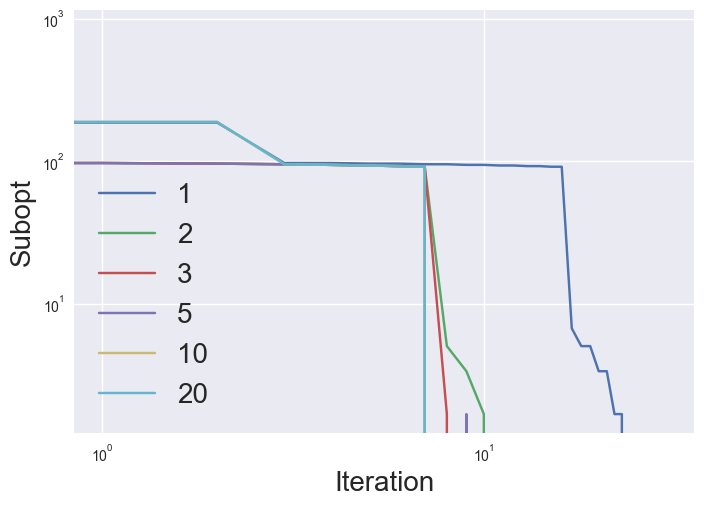

In [22]:
plot_log_lines(to_plot, 
           m_values, 
           ["Iteration", "Subopt"], "figs", "MPI.pdf", show = True)

**Questions** 
- How does the value of $m$ affect convergence ?
- Which is the cost per iteration of Modified Policy Iteration ?
- Which is the cost per iteration of Policy Iteration implemented with Option 2 in the slides ?

***Answers***

* question 1: m 越大似乎收敛越快，即迭代次数越少
* 

---
---
---

# **Ex 4: Q-Learning [15 pts.]**

现在我们可以使用 无模型-学习 了. 为了技术原因，我们在这部分专注于有限步长 MDPs，并比较两种探索策略。

1. **$\varepsilon$-greedy** (Watkins, Christopher John Cornish Hellaby. “Learning from Delayed Rewards.” PhD Thesis, King’s College, Cambridge United Kingdom, 1989.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Sample $b_h \sim \text{Bernoulli}(\varepsilon), \hat{a}_h \sim \text{Uniform}(\mathcal{A})$
      - Take action $a_h \leftarrow \left[(1-b_h) \left(\underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}\right) + b_h \hat{a}_h \right]$ and observe $x_{h+1}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha)Q_h(x_h,a_h) +\alpha\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1})\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$
2. **UCB bonuses** (Jin, Chi, Zeyuan Allen-Zhu, Sebastien Bubeck, and Michael I Jordan. “Is Q-Learning Provably Efficient?” In Advances in Neural Information Processing Systems, Vol. 31. Curran Associates, Inc., 2018. https://proceedings.neurips.cc/paper/2018/hash/d3b1fb02964aa64e257f9f26a31f72cf-Abstract.html.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ and $N_h(x,a) \leftarrow 0$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Take action $a_h \leftarrow \underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}$ and observe $x_{h+1}$
      - $t=N_h(x_h,a_h)\leftarrow N_h(x_h,a_h) + 1, \alpha_t = \frac{H+1}{H+t}$ and $b_t \leftarrow c\sqrt{\frac{H^3}{t}}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha_t)Q_h(x_h,a_h) +\alpha_t\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1}) + b_t\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$

由于其他技术原因，我们还需要将奖励重新缩放在 0 和 1 之间，如下所示

In [23]:
reward_mode = 0
size = 10
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

### **Q learning with $\varepsilon$ greedy**

In this subsection, we implement $Q$ Learning with the simplest possible exploration strategy: $\epsilon$-greedy.

In [24]:
def argmax_with_random_tie_breaking(b):
    return np.random.choice(np.where(b == b.max())[0])

In [25]:
def q_learning_epsilon_greedy(K: int = 100000, H: int = 20, epsilon: float = 0.1, alpha: float = 0.1) -> List[float]:
    """
    Function implementing the epsilon-greedy Q-learning algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param epsilon: Algorithm hyperparameter, exploration probability, float in [0, 1]
    :param alpha: Algorithm hyperparameter, Q update weight, float in [0, 1]

    :return: reward after each step, list of K * H floats
    """
    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            explore = np.random.binomial(2, p=epsilon)
            if explore:
                # Exploration: With probability epsilon take a random action
                a = np.random.choice(gridworld.n_actions)
            else:
                # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
                a = argmax_with_random_tie_breaking(Q[h, state, :])

            # Get reward for action
            rewards.append(gridworld.r[state, a])

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Update Q according to the algorithm
            Q[h, state, a] = ???

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.min([np.max(Q[h, state, :]), H])

            state = new_state
    return rewards

SyntaxError: invalid syntax (616483623.py, line 37)

In [ ]:
reward_eps_greedy = q_learning_epsilon_greedy()  # You can play around with the arguments if you like
cumulative_reward_eps_greedy = np.cumsum(reward_eps_greedy)

### Q-Learning with bonuses

In this subsection, you are asked to implement an optimistic version of  Q Learning suggested in (Jin et al., 2018)

In [ ]:
def q_learning_ucb_bonuses(K: int = 100000, H: int = 20, c: float = 0.0001) -> List[float]:
    """
    Function implementing the Q-learning with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param c: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0
    N = np.ones((H, gridworld.n_states, gridworld.n_actions))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # Take one of the optimal actions for the current state
            a = argmax_with_random_tie_breaking(Q[h, state, :])
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Calculate the UCB bonus
            bonus = c * np.sqrt(H ** 3 / N[h, state, a])

            # Calculate the adaptive alpha according to the algorithm
            alpha = (H + 1) / (H + N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = ???

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :])
            V[h, state] = np.clip(V[h, state], 0, H)

            state = new_state

    return rewards

In [ ]:
reward_UCB = q_learning_ucb_bonuses()  # You can play around with the arguments if you like
cumulative_reward_UCB = np.cumsum(reward_UCB)

### Comparison of exploration strategies

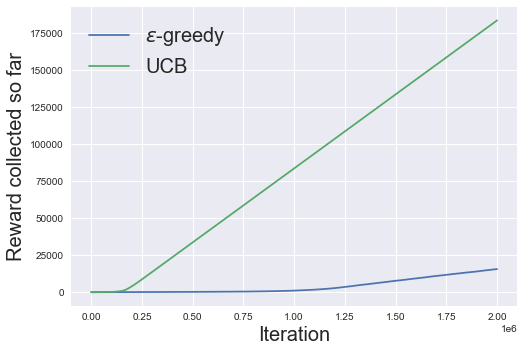

In [ ]:
plot_lines(
    [cumulative_reward_eps_greedy, cumulative_reward_UCB],
    [r"$\epsilon$-greedy", "UCB"],
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=False
)

**Question:** You are given an environment with $N$ states linked in a chain, i.e. from every state except the two endpoints there are two possible actions going right or go back to the first state in the chain. For the endpoints the second action is to stay in the same state. The reward is only 1 if you are in the rightmost state and stay there, otherwise 0. What is the probability that the $\varepsilon$-greedy algorithm will have a positive reward after $H$ steps in the first episode, if the chosen initial state is the leftmost state in the chain?

**Question:** Does the empirical result match the theoretical result described in (Jin et al. 2018) ? Try to answer this question after reading their Appendix A and looking at their Table 1 for the algorithm they call UCB-H.

## Monte Carlo (MC) and Time Differences (TD) ( * Question ) [25 points]

Disclaimer: The TA can not help you on this part of the notebook.

In [ ]:
def generate_episode(policy: List, H: int, initial_state: int):
    """
    Generate an episode using the given policy.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param H: Maximum number of steps in the episode.
    :param initial_state: Starting state.

    :return: A list of (state, action, reward) tuples.
    """
    episode = []
    state = initial_state
    for _ in range(H):
        action = policy[state]
        reward = gridworld.r[state, action]
        next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Monte Carlo policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        episode = generate_episode(policy, H, initial_state=99)  # Generate episode
        G = 0  # Return

        # Backward pass through the episode
        for t in range(len(episode) - 1, -1, -1):
            state, _, reward = episode[t]
            G = gamma * G + reward  # Discounted return

            # Update theta using gradient descent
            phi_s = phi[state]  # Feature vector for the current state
            V_hat = np.dot(theta, phi_s)  # Current value estimate
            theta += ???  # Gradient descent update

    return theta


In [ ]:

import numpy as np
def td_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Temporal Difference (TD) policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        state = 99  # Initial state
        for _ in range(H):  # Step loop
            # Sample action from policy
            action = policy[state]
            reward = gridworld.r[state, action]
            next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])

            # Compute TD target and TD error
            phi_s = phi[state]  # Feature vector for current state
            phi_s_next = phi[next_state]  # Feature vector for next state
            V_s = np.dot(theta, phi_s)  # Current value estimate
            V_s_next = np.dot(theta, phi_s_next)  # Next value estimate
            td_target = ???  # TD target
            td_error = ???  # TD error

            # Update theta using gradient descent
            theta += ???

            # Move to the next state
            state = next_state

    return theta

**Case 1:**

In [ ]:


_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

**Case 2:**

In [ ]:
_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
phi[:50,:]*=0

# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 1?
- Explain your answer writing down the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case. To give this answer you can assume that $\rho$ is positive everywhere.

**Answers**


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 2?
- Explain your answer leveraging the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case.